Generate training data using function for dx/dt

In [1]:
import torch
import torch.nn as nn
import numpy as np

# Define the ODE
def dxdt_func(x):
    dxdt = -2*x
    return dxdt

# Generate random training inputs
np.random.seed(0)
x_min, x_max = 0, 2
x = np.random.uniform(x_min, x_max, 500000)

# # Standardize the training inputs
# x_mean, x_std = np.mean(x), np.std(x)
# x_stand = (x - x_mean) / x_std

# Calculate the dydx training values
dxdt_train = dxdt_func(x)

# # Scale the training dydx values
# dxdt_mean, dxdt_std = np.mean(dxdt_train), np.std(dxdt_train)
# dxdt_scld = (dxdt_train - dxdt_mean) / dxdt_std

# dxdt_min, dxdt_max = np.min(dxdt_train), np.max(dxdt_train)
# dxdt_scld = (dxdt_train - dxdt_min) / (dxdt_max - dxdt_min) * 0.6 + 0.2

x = np.vstack((x))
input_train = torch.tensor(x, dtype=torch.float32)
dxdt_scld = torch.tensor(dxdt_train, dtype=torch.float32).view(-1, 1)

Define and train NN to approximate dx/dt with early stopping

In [44]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import copy

class ODENeuralNetwork(nn.Module):
    def __init__(self):
        super(ODENeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(1, 10) # 3 inputs (input layer) to hidden layer 1
        self.output_layer = nn.Linear(10, 1) # Hidden layer 3 to 1 output (output layer)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))

        # x = torch.relu(self.hidden1(x))
        # x = torch.relu(self.hidden2(x))
        x = (self.output_layer(x))
        return x
    
dxdt_model = ODENeuralNetwork()

batchsize = 500

# Create dataset and DataLoader for training in batches
dataset = TensorDataset(input_train, dxdt_scld)
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

loss_func = nn.MSELoss()
optimizer = optim.Adam(dxdt_model.parameters(), lr=0.01, weight_decay=0.01)
# Add weight decay
best_loss = float('inf')
patience = 10
patience_left = patience

# Train model
num_epochs = 150
for epoch in range(num_epochs):
    for x_batch, dxdt_batch in dataloader:
        # Evaluate model
        outputs = dxdt_model(x_batch)
        # Calculate loss
        loss = loss_func(outputs, dxdt_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Early stopping criteria
    if loss <= best_loss:
        best_loss = loss
        patience_left = patience
        best_model_weights = copy.deepcopy(dxdt_model.state_dict())
        best_epoch = epoch
    else:
        patience_left -= 1
        if patience_left == 0:
            break

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Use the best weights in the model
dxdt_model.load_state_dict(best_model_weights)

# Determine the best epoch and lost value when complete
print(f"Best epoch: {best_epoch}")
print(f"Smallest loss value: {best_loss:.8f}")




Epoch [10/150], Loss: 0.00009106
Epoch [20/150], Loss: 0.00014223
Best epoch: 11
Smallest loss value: 0.00005445


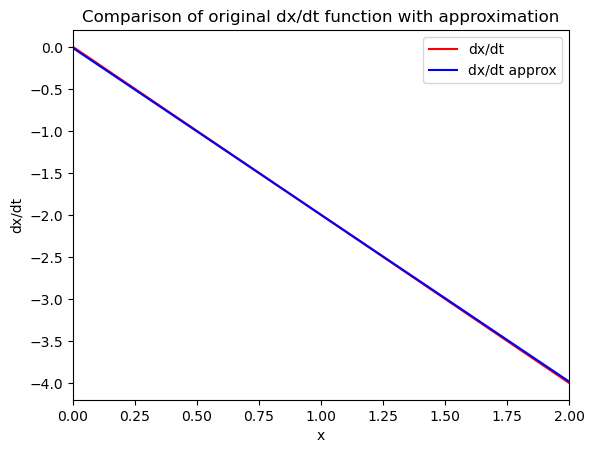

tensor([-2.9907])
-3.0


In [45]:
import matplotlib.pyplot as plt

x_plot = np.linspace(x_min, x_max, 1000)
# Make actual function
z1 = dxdt_func(x_plot)
shape_z1 = np.shape(z1)
zNN = np.zeros(shape=(shape_z1))

# Approximate with NN
def evaluations(x_test):
  
  x_test = torch.as_tensor([x_test], dtype=torch.float32)

  # Use NN model to determine the predicted output (dx/dt)
  dxdt_model.eval()
  with torch.no_grad():
    dxdt_pred = dxdt_model(x_test)
    
  return dxdt_pred

for i, x_test  in enumerate(x_plot):
    zNN[i] = evaluations(x_test)


plt.figure()
plt.plot(x_plot, z1, color='red', label='dx/dt')
plt.plot(x_plot, zNN, color='blue', label='dx/dt Approx.')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.legend(['dx/dt', 'dx/dt approx'])
plt.xlim([0, 2])
plt.title('Comparison of original dx/dt function with approximation')
plt.show()

print(evaluations(1.5))
print(dxdt_func(1.5))

In [46]:
import tempfile
import torch.onnx
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

input_bounds = [(x_min, x_max)]

# Make random data for batch size, input size (dummy input to trace the model)
dxdt_trace = torch.randn(batchsize, 1, requires_grad=True)
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        dxdt_model,
        dxdt_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    pytorch_model = f.name

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpyvg3nloa.onnx


In [47]:
import os
from omlt.neuralnet import FullSpaceNNFormulation, ReluComplementarityFormulation
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt import OmltBlock

# Import NN from ONNX with specified bounds
nn_omlt = load_onnx_neural_network_with_bounds(pytorch_model)
# Remove the temporary file created
os.remove(pytorch_model)

# Confirm layers and bounds
print(nn_omlt.scaled_input_bounds)
for layer_id, layer in enumerate(nn_omlt.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

{0: (0, 2)}
0	InputLayer(input_size=[1], output_size=[1])	linear
1	DenseLayer(input_size=[1], output_size=[10])	relu
2	DenseLayer(input_size=[10], output_size=[1])	linear


In [48]:
import pyomo.environ as pyo
from omlt.neuralnet import FullSpaceNNFormulation, ReluComplementarityFormulation
import pyomo.dae as dae
import torch.nn as nn

# Define the Pyomo model
m = pyo.ConcreteModel()

# Define the neural network
m.nn = OmltBlock()
formulation_mixed = ReluComplementarityFormulation(nn_omlt)
m.nn.build_formulation(formulation_mixed)

# Define a range of times to solve
t0 = 0
tend = 1
m.t = dae.ContinuousSet(bounds=(t0, tend))

# Define variables
m.x = pyo.Var(m.t, bounds=(0, 2))
m.x0 = pyo.Var(initialize=2)
m.dxdt = dae.DerivativeVar(m.x, wrt=m.t)

# Discretize wrt time to approximate x(t)
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=1, ncp=3, scheme='LAGRANGE-RADAU')

# Define the target for x at tend
x_target = 0.2

# Define initial condition constraint after discretization
def init_condition(m):
    return m.x[t0] == m.x0
m.init_condition = pyo.Constraint(rule=init_condition)

def connect_input(m, t):
    return m.x[t] == m.nn.inputs[0]
m.inputs = pyo.Constraint(m.t, rule=connect_input)

# Define the neural network input and connect m.dxdt to nn output after discretization
def connect_output(m, t):
    return m.dxdt[t] == m.nn.outputs[0]
m.outputs = pyo.Constraint(m.t, rule=connect_output)

# Define the objective
def objective_rule(m):
    return (x_target - m.x[tend])**2
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
results = solver.solve(m, tee=True)
finalx = pyo.value(m.x[tend])
solution = pyo.value(m.x0)

print("Final value of x at t =", tend, ":", finalx)
print('Initial x value: ', solution)



Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      104
Number of nonzeros in inequality constraint Jacobian.:       30
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:       46
                     variables with only lower bounds:       10
                variables with lower and upper bounds:       17


In [49]:
m.nn.inputs.pprint()
m.nn.outputs.pprint()
m.inputs.pprint()
m.outputs.pprint()

print('m.x[tend]: ', pyo.value(m.x[tend]))
print('m.dxdt[tend]: ', pyo.value(m.dxdt[tend]))


inputs : Size=1, Index=nn.inputs_set
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :     2 : False : False :  Reals
outputs : Size=1, Index=nn.outputs_set
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :  None : -7.62006374942266e-12 :  None : False : False :  Reals
inputs : Size=4, Index=t, Active=True
    Key      : Lower : Body                       : Upper : Active
           0 :   0.0 :        x[0] - nn.inputs[0] :   0.0 :   True
    0.155051 :   0.0 : x[0.155051] - nn.inputs[0] :   0.0 :   True
    0.644949 :   0.0 : x[0.644949] - nn.inputs[0] :   0.0 :   True
           1 :   0.0 :        x[1] - nn.inputs[0] :   0.0 :   True
outputs : Size=4, Index=t, Active=True
    Key      : Lower : Body                           : Upper : Active
           0 :   0.0 :        dxdt[0] - nn.outputs[0] :   0.0 :   True
    0.155051 :   0.0 : dxdt[0.155051] - nn.outputs[0] :   0.0 :   True
    0.644949 :   0.0 : dxdt[0.644949] -

[0. 0. 0. 0.]


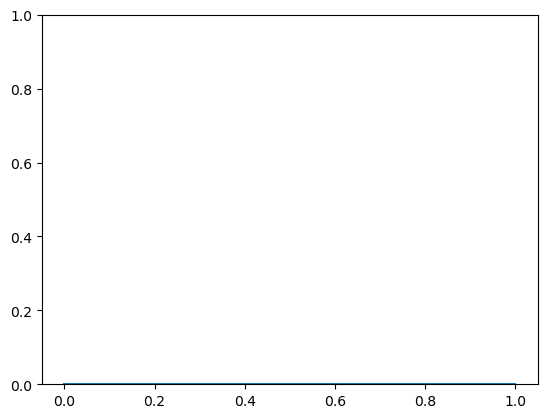

In [50]:
import matplotlib.pyplot as plt
# Extract the results
time = np.array([t for t in m.t])
x_values = np.array([pyo.value(m.x[t]) for t in m.t])
print(x_values)

plt.figure()
plt.plot(time, x_values)
plt.ylim([0, 1])
plt.show()


Define the functions to use when solving for x0

In [9]:
import pyomo.environ as pyo
from omlt.neuralnet import FullSpaceNNFormulation, ReluComplementarityFormulation
import pyomo.dae as dae
import torch.nn as nn

# Define dx/dt function
def dxdt_eval(x):
    # Convert to torch tensor to evaluate NN
    x_test = torch.as_tensor([pyo.value(x)], dtype=torch.float32)

    dxdt_model.eval()
    with torch.no_grad():
        dxdt_nn = dxdt_model(x_test)

    return dxdt_nn.item()

# Define the Pyomo model
m = pyo.ConcreteModel()

# Define a range of times to solve
t0 = 0
tend = 1
m.t = dae.ContinuousSet(bounds=(t0, tend))

# Define variables
m.x = pyo.Var(m.t)
m.x0 = pyo.Var(initialize=1)
m.dxdt = dae.DerivativeVar(m.x, wrt=m.t)

# Discretize wrt time to approximate x(t)
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m, nfe=3, ncp=3, scheme='LAGRANGE-RADAU')

# Define the target for x at tend
x_target = 0.5

# Define initial condition constraint after discretization
def init_condition(m):
    return m.x[t0] == m.x0
m.init_condition = pyo.Constraint(rule=init_condition)

# Define the neural network input and connect m.dxdt to nn output after discretization
def connect_output(m, t):
    # Ensure the input to the neural network is a scalar
    return m.dxdt[t] == dxdt_eval((m.x[t]))
m.outputs = pyo.Constraint(m.t, rule=connect_output)

# Define the objective
def objective_rule(m):
    return (x_target - m.x[tend])**2
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
results = solver.solve(m, tee=True)
finalx = pyo.value(m.x[tend])
solution = pyo.value(m.x0)

print("Final value of x at t =", tend, ":", finalx)
print('Initial x value: ', solution)



ERROR: evaluating object as numeric value: x[0]
        (object: <class 'pyomo.core.base.var.VarData'>)
    No value for uninitialized NumericValue object x[0]
ERROR: Rule failed when generating expression for Constraint outputs with
index 0: ValueError: No value for uninitialized NumericValue object x[0]
ERROR: Constructing component 'outputs' from data=None failed:
        ValueError: No value for uninitialized NumericValue object x[0]


ValueError: No value for uninitialized NumericValue object x[0]